In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in combined sample S2/S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [3]:
import importlib

## Preprocessing
### Read data

In [5]:
data_path = "../../data/MOBA_scRNAseq"
data_gene = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")


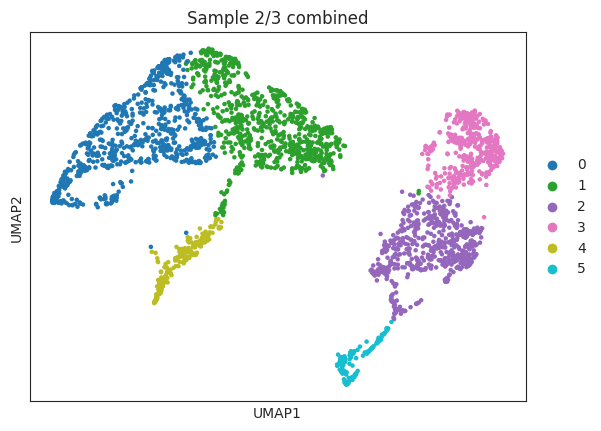

In [47]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 2/3 combined")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [6]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params


Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 2500
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 2600
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 4600
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 4700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 

## Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 409.615023042226
Factor: 2 - Error: 413.8789826873463
Factor: -0.618034 - Error: 558.6705053819143
Factor: 1 - Error: 409.615023042226
Factor: 0.38196600897566 - Error: 548.3901780610944
Factor: 1.38196601 - Error: 394.22308325838003
Factor: 1.6180339872046798 - Error: 399.2624407322285
Factor: 1.2360679772046799 - Error: 393.0812399699656
Factor: 1.1458980338630373 - Error: 393.7573474583769
Factor: 1.2917960666583574 - Error: 393.24356468656464
Factor: 1.2016261237245467 - Error: 393.49682167447327
Factor: 1.2573542131782243 - Error: 392.921256031527
Factor: 1.2705098305290354 - Error: 393.531608538442
Factor: 1.249223594555491 - Error: 393.30993202664854
Factor: 1.2623792118468002 - Error: 393.13774020882124
Factor: 1.2542485932240672 - Error: 392.6969785759355
Factor: 1.252329214532376 - Error: 393.00993041624554
Factor: 1.255434834486533 - Error: 392.63648445499905
Factor: 1.2561679719070773 - Error: 392.34359717071465
Factor: 1.2566210757523146 - Error: 392.672

In [8]:
# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [9]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [10]:
data_null_gen.var_names

Index(['PA0001', 'PA0002', 'PA0003', 'PA0004', 'PA0005', 'PA0006', 'PA0007',
       'PA0008', 'PA0009', 'PA0010',
       ...
       'PA5561', 'PA5562', 'PA5563', 'PA5564', 'PA5565', 'PA5566', 'PA5567',
       'PA5568', 'PA5569', 'PA5570'],
      dtype='object', name='index', length=5557)

In [11]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [12]:
data_null_gen.var

var_counts  mean_counts
index                          
PA0001    0.897422     0.693486
PA0002    0.783557     0.540669
PA0003    1.512468     0.955634
PA0004    0.537958     0.417782
PA0005    0.211074     0.154225
...            ...          ...
PA5566    0.007518     0.007218
PA5567    0.240438     0.170599
PA5568    0.917783     0.684331
PA5569   13.943870     3.598239
PA5570    0.887991     0.480282

[5557 rows x 2 columns]

In [13]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

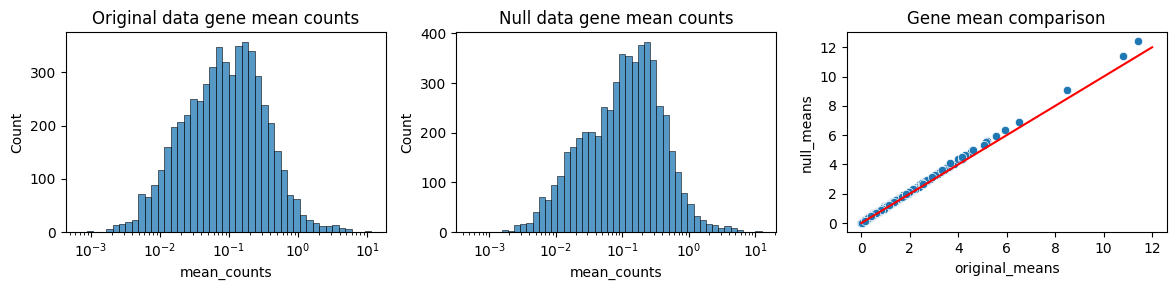

SignificanceResult(statistic=0.9990024258533897, pvalue=0.0)


In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

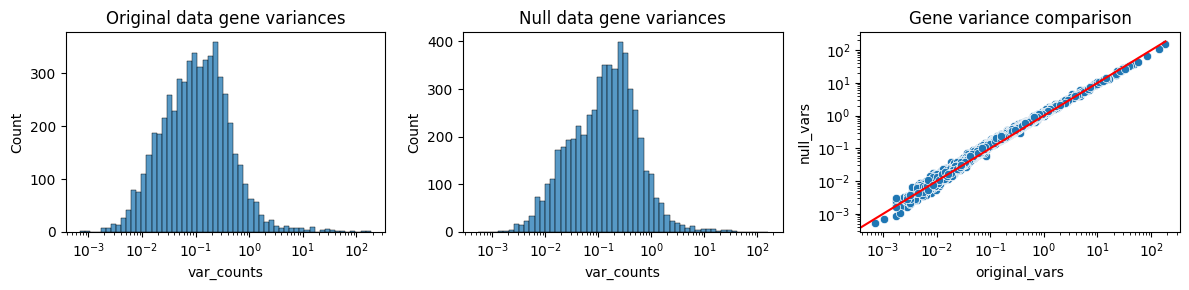

SignificanceResult(statistic=0.9981416731102386, pvalue=0.0)
[[1.         0.99720431]
 [0.99720431 1.        ]]


In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

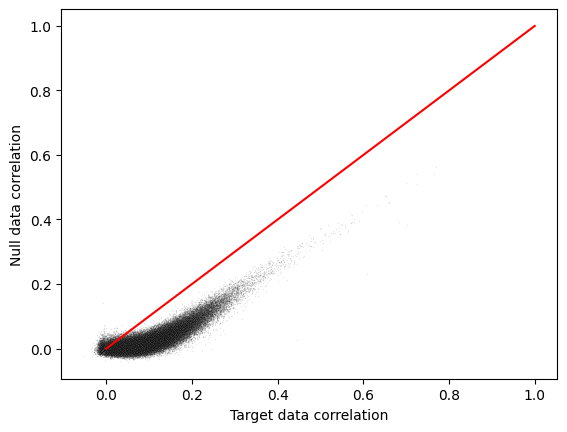

In [16]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [17]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [18]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


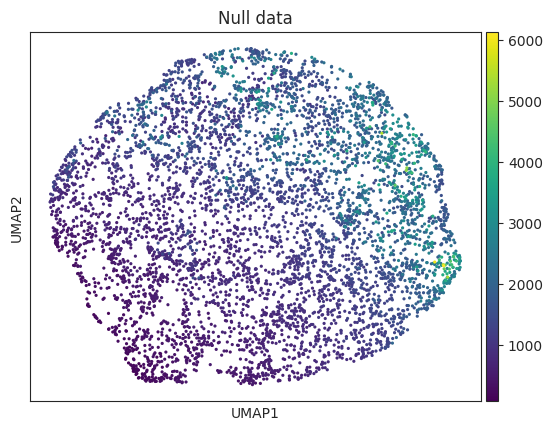

In [45]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [20]:
data_path = "../../data/MOBA_scRNAseq"
data_null_gen.write(data_path + "/null_data_S2S3_combined.h5ad")

In [6]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_S2S3_combined.h5ad")
data_null_gen

AnnData object with n_obs × n_vars = 5680 × 5557
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'var_counts', 'mean_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'n_cells_by_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [7]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01
    
    while twoclust is False:
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5*res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 15)

            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5*res_step
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

/tmp/ipykernel_3049978/3705816167.py:17: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)


resolution: 0.01, clusters: 1
resolution: 0.035, clusters: 1
resolution: 0.06, clusters: 1
resolution: 0.085, clusters: 1
resolution: 0.11, clusters: 2
split 1/1 - Resolution 0.11
Best split: No. 0 - seed: 979 - minimal p-value: 3.799772504835432e-173


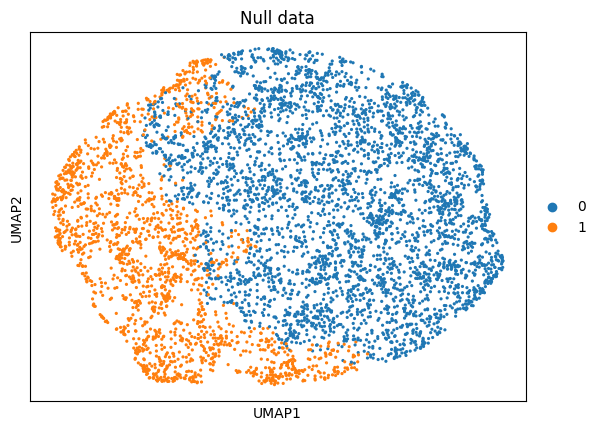

In [9]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [10]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_S2S3_combined.h5ad")

In [25]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 3 - DE genes: 0; Minimum q value: 0.12
Cluster 0 - DE genes: 24; Minimum q value: 0.041666666666666664
Cluster 2 - DE genes: 43; Minimum q value: 0.025
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 4 - DE genes: 50; Minimum q value: 0.025
Cluster 5 - DE genes: 34; Minimum q value: 0.029411764705882353


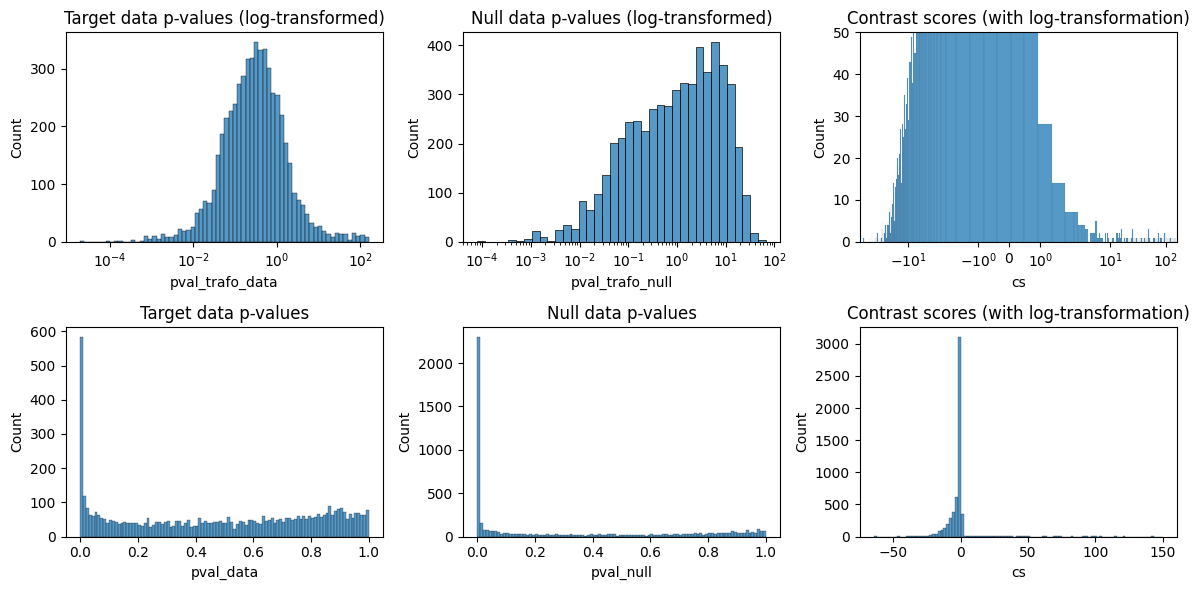

In [26]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [27]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 3
0.120000      25
0.125000       7
0.176471       2
0.209302       9
0.250000       1
0.266667       1
0.282609       1
0.285714       3
0.300000       1
0.450980       1
0.557692       1
0.579809    3187
0.579840       5
0.579969       1
0.580099       1
0.580110      12
0.580319       4
0.580398       3
0.580734       5
0.580813       3
0.580941       1
0.581069       1
0.581807       1
0.582217       8
0.582648       1
0.582775       1
0.583460       3
0.583713       2
0.583840       1
0.584317      11
0.585167      14
0.585292       1
0.585564       7
0.585877      17
0.585949       3
0.586022       3
0.586145       1
0.586156      46
0.586278       1
0.586816       2
0.587059       2
0.587180       1
0.588598       2
0.588667       3
0.589945      35
0.590354       1
0.590473       1
0.590592       1
0.590596      44
0.591000       1
1.000000    2068
Name: q, dtype: int64

cluster 0
0.041667      24
0.096774       7
0.117647       3
0.142857       1
0.146341       6
0.159

In [28]:
pvals_log_gen["0"]

pval_data     pval_null  pval_trafo_data  pval_trafo_null  \
index                                                                   
PA4264  1.814942e-145  2.438943e-05       144.741137         4.612798   
PA4256  1.999398e-134  2.627500e-08       133.699101         7.580457   
PA4260  5.347137e-134  6.209005e-12       133.271879        11.206978   
PA4262  3.471797e-135  7.374225e-15       134.459446        14.132284   
PA4250  9.737854e-118  1.105816e-03       117.011537         2.956317   
...               ...           ...              ...              ...   
PA3193   6.659801e-02  4.792211e-54         1.176539        53.319464   
PA3107   7.894523e-02  2.082095e-54         1.102674        53.681499   
PA5461   1.142806e-09  9.317979e-67         8.942028        66.030678   
PA1838   1.088849e-05  9.407507e-79         4.963032        78.026525   
PA5315   7.086775e-02  1.459765e-77         1.149551        76.835717   

                cs         q  
index                         
PA4264  140.128339  0.041667  
PA4256  126.118643  0.041667  
PA4260  122.064901  0.041667  
PA4262  120.327162  0.041667  
PA4250  114.055220  0.041667  
...            ...       ...  
PA3193  -52.142925  1.000000  
PA3107  -52.578825  1.000000  
PA5461  -57.088651  1.000000  
PA1838  -73.063493  1.000000  
PA5315  -75.686166  1.000000  

[5557 rows x 6 columns]

In [29]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [30]:
data_gene_nonzero.write(data_path + "/S2S3_combined_data_maxpool_processed_cluster.h5ad")

In [31]:
data_gene_nonzero = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed_cluster.h5ad")

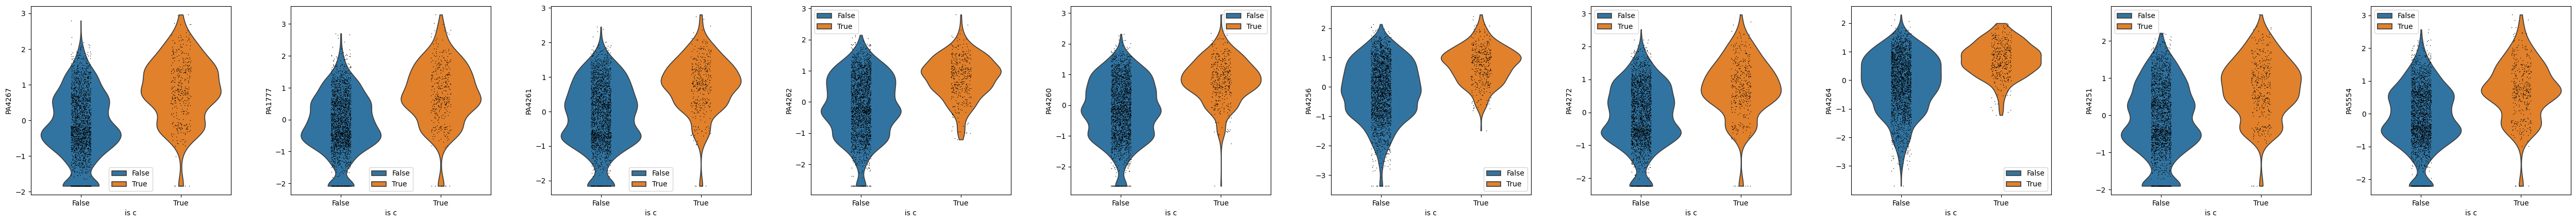

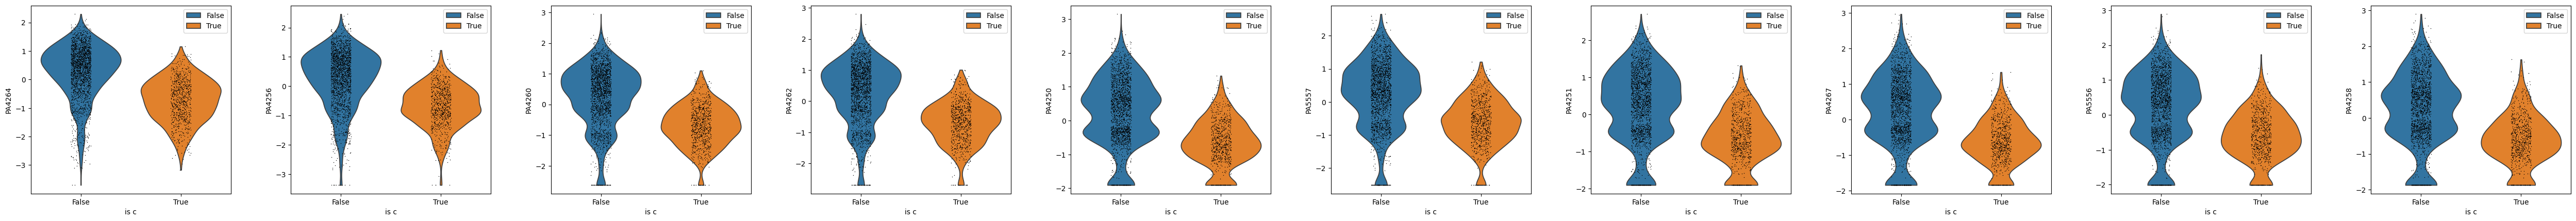

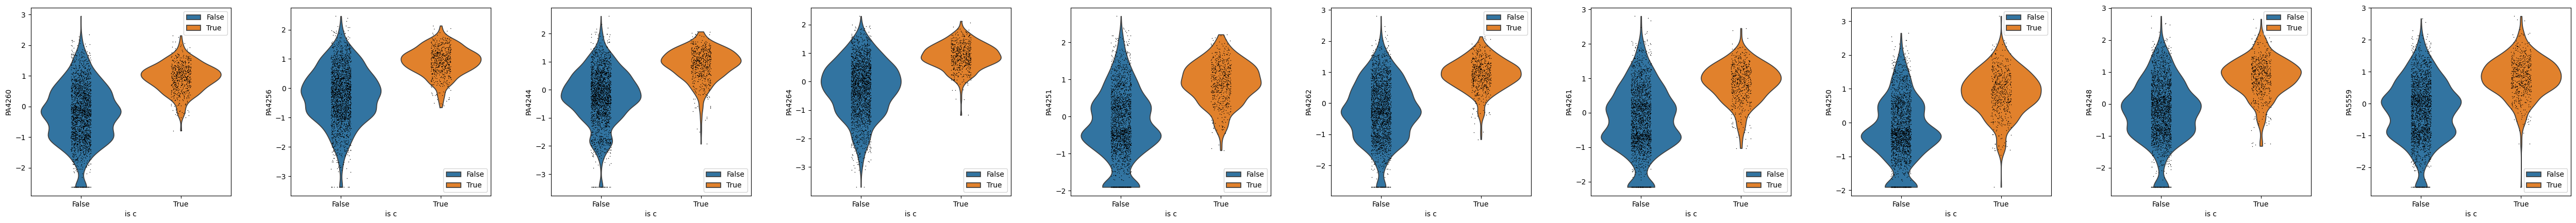

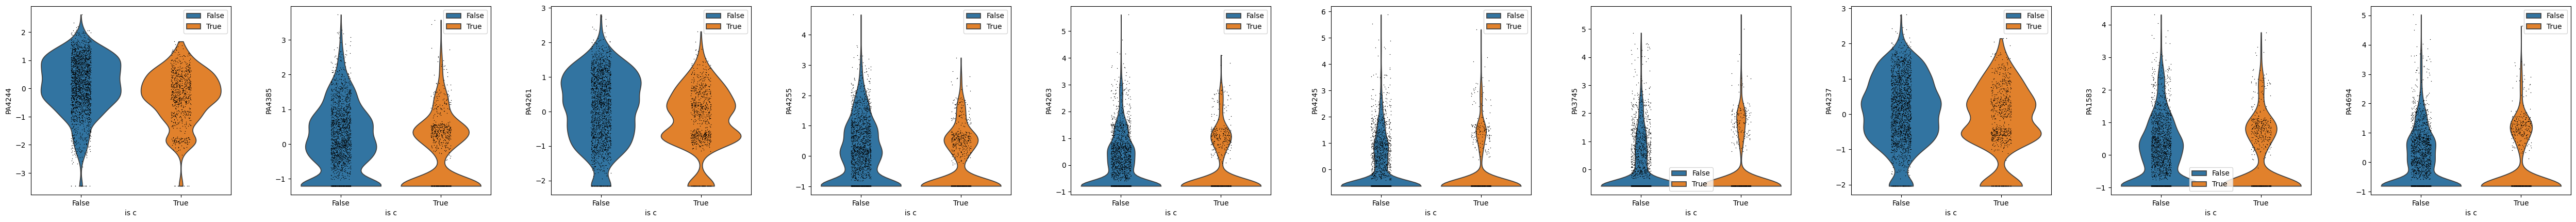

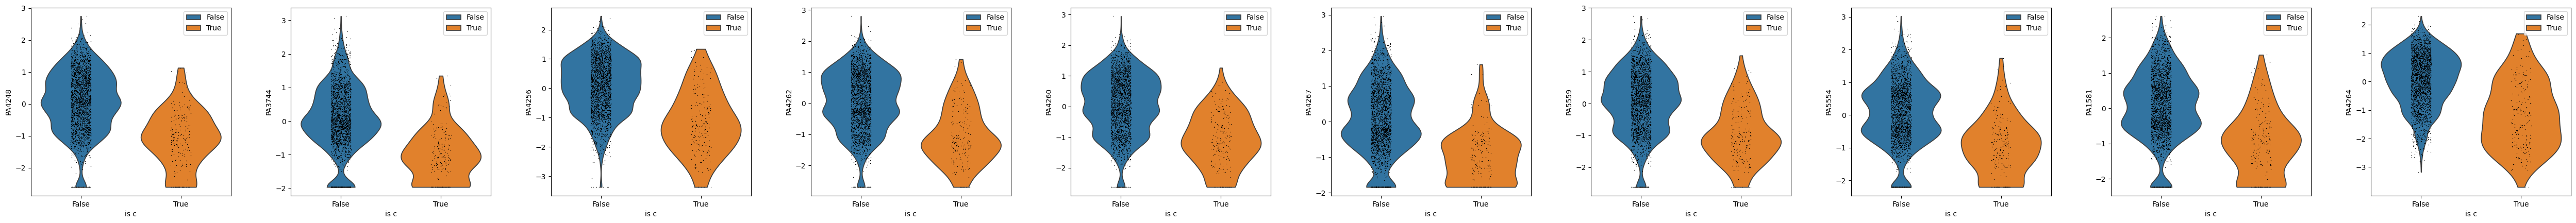

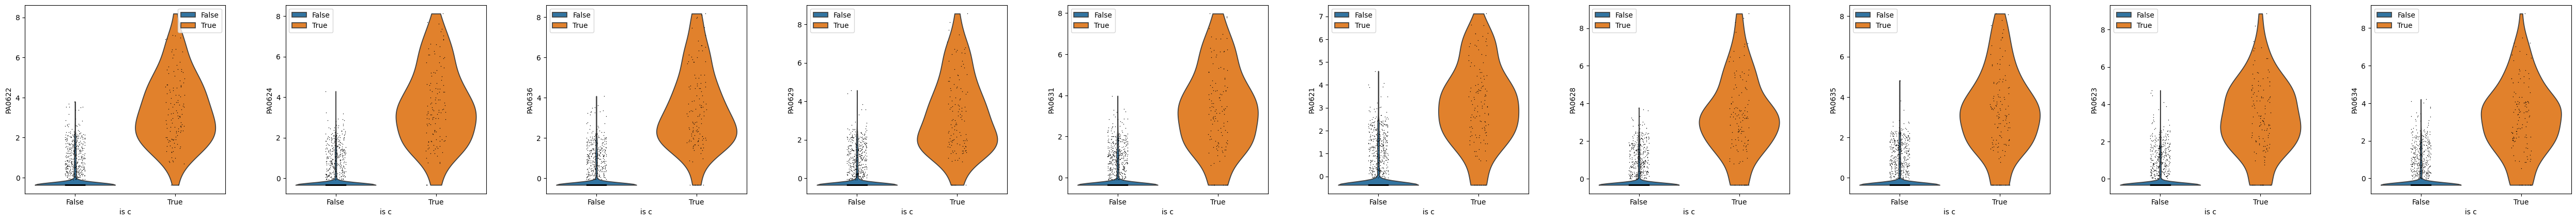

In [32]:
clusters = data_gene.obs["leiden_opt"].unique()
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [33]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
index                                                       
PA0001               1283     0.631690           0.489616   
PA0002                958     0.459155           0.377857   
PA0003               1535     0.866549           0.624091   
PA0004                804     0.359507           0.307122   
PA0005                303     0.122535           0.115590   
...                   ...          ...                ...   
PA5566                 21     0.007746           0.007717   
PA5567                317     0.132746           0.124645   
PA5568               1243     0.616197           0.480076   
PA5569               2575     3.328521           1.465226   
PA5570                794     0.414789           0.346980   

        pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
index                                                                      
PA0001              54.823944        1794.0            7.492760     1283   
PA0002              66.267606        1304.0            7.173958      958   
PA0003              45.950704        2461.0            7.808729     1535   
PA0004              71.690141        1021.0            6.929517      804   
PA0005              89.330986         348.0            5.855072      303   
...                       ...           ...                 ...      ...   
PA5566              99.260563          22.0            3.135494       21   
PA5567              88.838028         377.0            5.934894      317   
PA5568              56.232394        1750.0            7.467942     1243   
PA5569               9.330986        9453.0            9.154193     2575   
PA5570              72.042254        1178.0            7.072422      794   

        var_counts  is_scd_outlier  nb_overdisp  ...  Protein accession  \
index                                            ...                      
PA0001    0.740404           False    14.442875  ...        NP_064721.1   
PA0002    0.605374           False    10.737965  ...        NP_064722.1   
PA0003    1.239585           False    14.794146  ...        NP_064723.1   
PA0004    0.415473           False     8.322133  ...        NP_064724.1   
PA0005    0.143436           False     2.121336  ...        NP_064725.1   
...            ...             ...          ...  ...                ...   
PA5566    0.008391           False     0.091676  ...        NP_254253.1   
PA5567    0.161604           False     2.316907  ...        NP_254254.1   
PA5568    0.748470           False    14.179352  ...        NP_254255.1   
PA5569   14.483975           False     5.282664  ...        NP_254256.1   
PA5570    0.667387           False     9.060326  ...        NP_254257.1   

                                                   Name  Symbol  gene_mean  \
index                                                                        
PA0001            chromosome replication initiator DnaA    dnaA   0.631690   
PA0002                  DNA polymerase III subunit beta    dnaN   0.459155   
PA0003          DNA replication and repair protein RecF    recF   0.866549   
PA0004                             DNA gyrase subunit B    gyrB   0.359507   
PA0005            lysophosphatidic acid acyltransferase    lptA   0.122535   
...                                                 ...     ...        ...   
PA5566                             hypothetical protein     NaN   0.007746   
PA5567                    tRNA modification GTPase TrmE     NaN   0.132746   
PA5568  inner membrane protein translocase subunit YidC     NaN   0.616197   
PA5569                                   ribonuclease P    rnpA   3.328521   
PA5570                        50S ribosomal protein L34    rpmH   0.414789   

         gene_var  mean_var_diff  gene_dist  est_mean est_overdisp  \
index                                                                
PA0001   0.740404      -0.108714         nb  0.631691     4.163086   
PA0002   0.605374      -

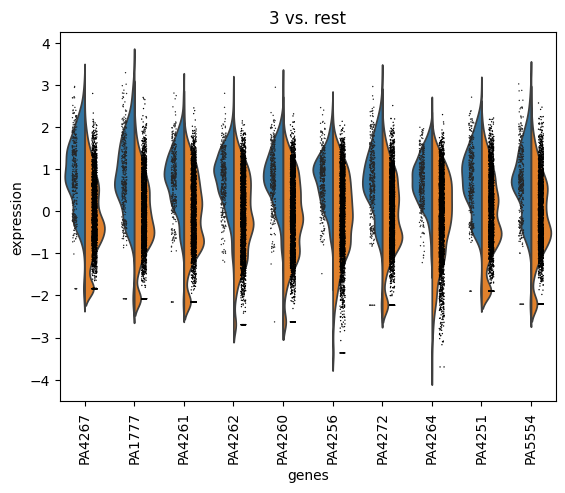

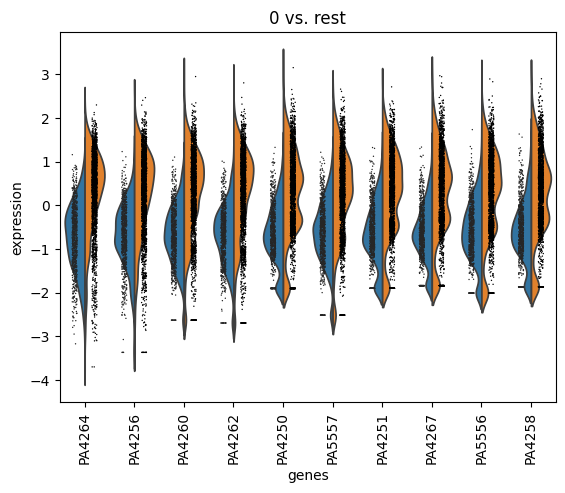

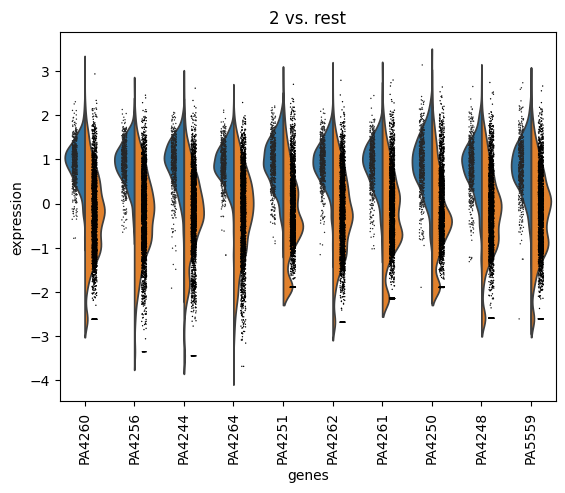

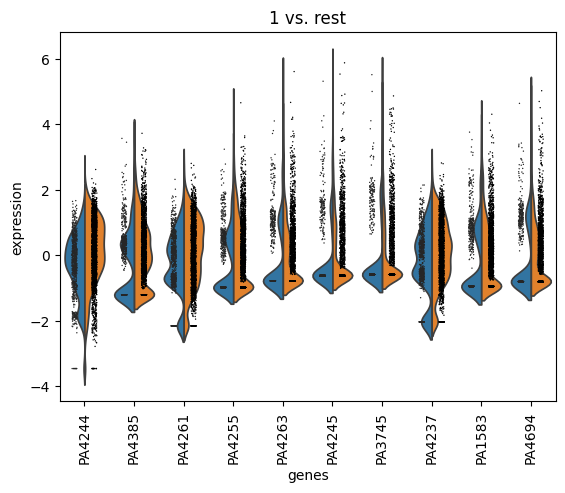

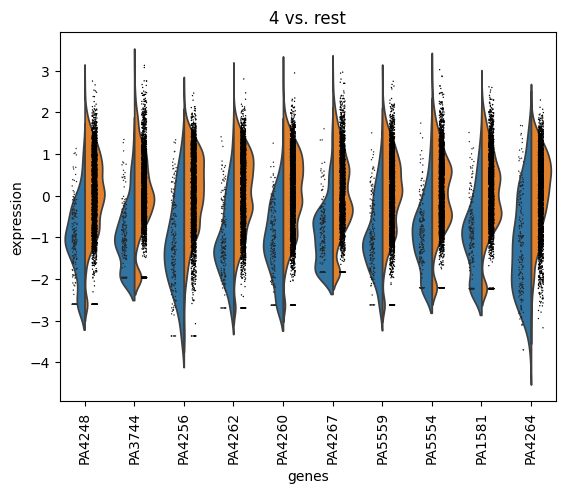

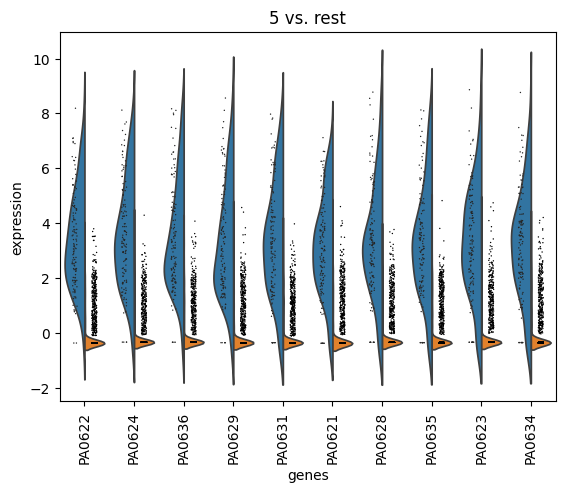

In [34]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [35]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
index                                                       
PA0001               1283     0.631690           0.489616   
PA0002                958     0.459155           0.377857   
PA0003               1535     0.866549           0.624091   
PA0004                804     0.359507           0.307122   
PA0005                303     0.122535           0.115590   
...                   ...          ...                ...   
PA5566                 21     0.007746           0.007717   
PA5567                317     0.132746           0.124645   
PA5568               1243     0.616197           0.480076   
PA5569               2575     3.328521           1.465226   
PA5570                794     0.414789           0.346980   

        pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
index                                                                      
PA0001              54.823944        1794.0            7.492760     1283   
PA0002              66.267606        1304.0            7.173958      958   
PA0003              45.950704        2461.0            7.808729     1535   
PA0004              71.690141        1021.0            6.929517      804   
PA0005              89.330986         348.0            5.855072      303   
...                       ...           ...                 ...      ...   
PA5566              99.260563          22.0            3.135494       21   
PA5567              88.838028         377.0            5.934894      317   
PA5568              56.232394        1750.0            7.467942     1243   
PA5569               9.330986        9453.0            9.154193     2575   
PA5570              72.042254        1178.0            7.072422      794   

        var_counts  is_scd_outlier  nb_overdisp  ...  Protein accession  \
index                                            ...                      
PA0001    0.740404           False    14.442875  ...        NP_064721.1   
PA0002    0.605374           False    10.737965  ...        NP_064722.1   
PA0003    1.239585           False    14.794146  ...        NP_064723.1   
PA0004    0.415473           False     8.322133  ...        NP_064724.1   
PA0005    0.143436           False     2.121336  ...        NP_064725.1   
...            ...             ...          ...  ...                ...   
PA5566    0.008391           False     0.091676  ...        NP_254253.1   
PA5567    0.161604           False     2.316907  ...        NP_254254.1   
PA5568    0.748470           False    14.179352  ...        NP_254255.1   
PA5569   14.483975           False     5.282664  ...        NP_254256.1   
PA5570    0.667387           False     9.060326  ...        NP_254257.1   

                                                   Name  Symbol  gene_mean  \
index                                                                        
PA0001            chromosome replication initiator DnaA    dnaA   0.631690   
PA0002                  DNA polymerase III subunit beta    dnaN   0.459155   
PA0003          DNA replication and repair protein RecF    recF   0.866549   
PA0004                             DNA gyrase subunit B    gyrB   0.359507   
PA0005            lysophosphatidic acid acyltransferase    lptA   0.122535   
...                                                 ...     ...        ...   
PA5566                             hypothetical protein     NaN   0.007746   
PA5567                    tRNA modification GTPase TrmE     NaN   0.132746   
PA5568  inner membrane protein translocase subunit YidC     NaN   0.616197   
PA5569                                   ribonuclease P    rnpA   3.328521   
PA5570                        50S ribosomal protein L34    rpmH   0.414789   

         gene_var  mean_var_diff  gene_dist  est_mean est_overdisp  \
index                                                                
PA0001   0.740404      -0.108714         nb  0.631691     4.163086   
PA0002   0.605374      -

In [36]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["Locus tag", "Name", "Symbol"]])

Cluster 3
       Locus tag                       Name Symbol
index                                             
PA4267    PA4267   30S ribosomal protein S7   rpsG
PA1777    PA1777     outer membrane porin F   oprF
PA4261    PA4261  50S ribosomal protein L23   rplW
PA4262    PA4262   50S ribosomal protein L4   rplD
PA4260    PA4260   50S ribosomal protein L2   rplB
PA4256    PA4256  50S ribosomal protein L16   rplP
PA4272    PA4272  50S ribosomal protein L10   rplJ
PA4264    PA4264  30S ribosomal protein S10   rpsJ
PA4251    PA4251   50S ribosomal protein L5   rplE
PA5554    PA5554  ATP synthase subunit beta   atpD
Cluster 0
       Locus tag                        Name Symbol
index                                              
PA4264    PA4264   30S ribosomal protein S10   rpsJ
PA4256    PA4256   50S ribosomal protein L16   rplP
PA4260    PA4260    50S ribosomal protein L2   rplB
PA4262    PA4262    50S ribosomal protein L4   rplD
PA4250    PA4250   30S ribosomal protein S14   rpsN
PA55

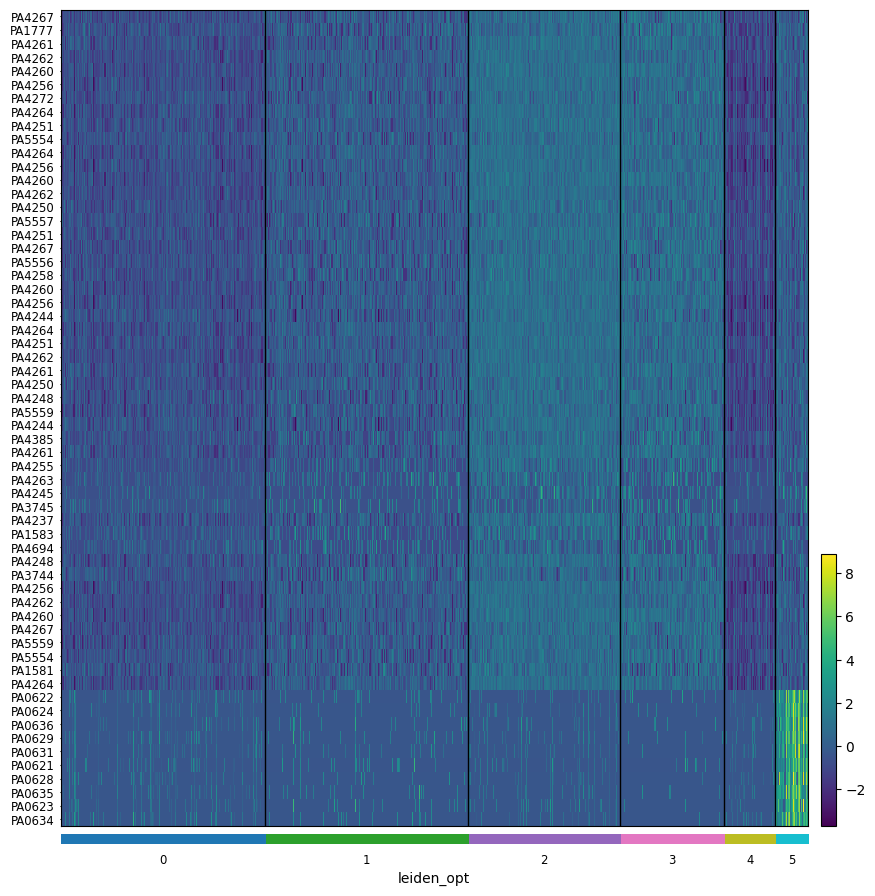

In [37]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes

sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True)

In [11]:
!pip install pertpy[coda]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 174.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 141.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 127.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 136.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.5/265.5 kB 134.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.2/202.2 kB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 100.8 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 181.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 173.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 181.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 147.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 291.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 227.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 246.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 211.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 132.8 MB/s eta 0:00:00
  Created wheel for blitzgsea: filename=blitzgsea-1.3.40-py3-none-any.whl size=97418 sha256=44c0d3de1e97cbf3ddea

In [39]:
import pertpy as pt


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

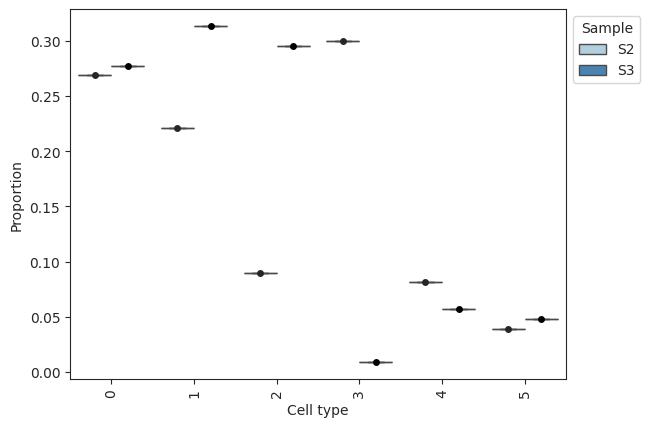

In [40]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    data_gene_nonzero,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden_opt",
    sample_identifier=["Sample"],
)
sccoda_data["coda"].obs["Sample"] = sccoda_data["coda"].obs.index
# plot boxplots
pt.pl.coda.boxplots(sccoda_data, modality_key="coda", feature_name="Sample", add_dots=True)
plt.show()

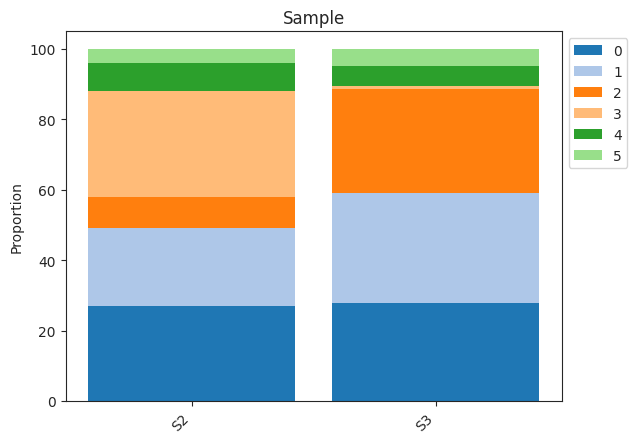

In [41]:
pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="Sample")
plt.show()

In [42]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="Sample",
    reference_cell_type="automatic",
)


Automatic reference selection! Reference cell type set to 0

In [43]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=3456)
sccoda_data["coda"]

sample: 100%|██████████| 11000/11000 [00:23<00:00, 464.97it/s, 63 steps of size 3.11e-02. acc. prob=0.76] 


AnnData object with n_obs × n_vars = 2 × 6
    obs: 'Sample'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_Sample[T.S3]'

In [44]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.2)
sccoda_model.summary(sccoda_data, modality_key="coda", extended=True)


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 2 samples, 6 cell types                                           │
│ Reference cell type                   │ 0                                                                       │
│ Formula                               │ Sample                                                                  │
│ Reference index                       │ 0                                                                       │
│ Spike-and-slab threshold              │ 0.716                                                                   │
│ Spike-and-slab threshold              │ 0.716                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (1000 burnin samples)                        │
│ Acceptance rate                       │ 75.7%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                                              │
│ Cell Type                                                                                                       │
│ 0              2.582         0.344  4.902   1.250     395.228                                                   │
│ 1              2.499         0.198  4.745   1.250     363.749                                                   │
│ 2              1.749        -0.391  3.883   1.138     171.823                                                   │
│ 3              2.343        -0.942  5.050   1.701     311.208                                                   │
│ 4              1.298        -1.098  3.624   1.262     109.449                                                   │
│ 5              0.830        -1.416  3.118   1.217      68.543                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                       Final Parameter  Expected Sample  log2-fold change                                        │
│ Covariate  Cell Type                                                                                            │
│ SampleT.S3 0               0.000          406.930             0.042                                             │
│            1               0.000          374.519             0.042                                             │
│            2               0.885          428.589             1.319                                             │
│            3              -2.485           26.700            -3.543                                             │
│            4               0.000          112.690             0.042                                             │
│            5               0.000           70.573             0.042                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                       HDI 3%  HDI 97%   SD   Inclusion probability                                              │
│ Covariate  Cell Type                                                                                            │
│ SampleT.S3 0           0.000  0.000   0.000         0.000                                                       │
│            1          -0.645  1.221   0.308         0.364                                                       │
│            2          -0.223  1.965   0.666         0.717                                                       │
│            3          -4.318  0.137   1.416         0.887                                                       │
│            4          -1.526  0.949   0.430         0.400                                                       │
│            5          -1.160  1.531   0.421         0.370                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘